In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive/Deep Learning"

Mounted at /content/drive
/content/drive/MyDrive/Deep Learning


In [37]:
"""
# Solo se realiza una vez, para que se cree el folder y se divida el dataset
import os, shutil, pathlib
  
original_dir = pathlib.Path("train")                           
new_base_dir = pathlib.Path("elephant_small_tt")              
 
def make_subset(subset_name, start_index, end_index):          
    for category in ("af_tr", "as_tr"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}{i}.jpg" 
                  for i in range(start_index, end_index)]
        for fname in fnames:
          shutil.copyfile(src=original_dir / fname, dst=dir / fname)
  
make_subset("train", start_index=1, end_index=70)    
make_subset("validation", start_index=41, end_index=110)
make_subset("test", start_index=111, end_index=156)
"""

'\n# Solo se realiza una vez, para que se cree el folder y se divida el dataset\nimport os, shutil, pathlib\n  \noriginal_dir = pathlib.Path("train")                           \nnew_base_dir = pathlib.Path("elephant_small_tt")              \n \ndef make_subset(subset_name, start_index, end_index):          \n    for category in ("af_tr", "as_tr"):\n        dir = new_base_dir / subset_name / category\n        os.makedirs(dir)\n        fnames = [f"{category}{i}.jpg" \n                  for i in range(start_index, end_index)]\n        for fname in fnames:\n          shutil.copyfile(src=original_dir / fname, dst=dir / fname)\n  \nmake_subset("train", start_index=1, end_index=70)    \nmake_subset("validation", start_index=41, end_index=110)\nmake_subset("test", start_index=111, end_index=156)\n'

In [3]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")                           
new_base_dir = pathlib.Path("elephant_small_ttv")

In [4]:
# Creación del modelo
from tensorflow import keras 
from keras import layers

model = keras.Sequential([keras.Input(shape=(180, 180, 3)),
                          layers.Rescaling(1./255),
                          layers.Conv2D(filters=128, kernel_size=3, activation="softmax"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="softmax"),
                          layers.MaxPooling2D(pool_size=2),
                          layers.Conv2D(filters=256, kernel_size=3, activation="softmax"),
                          layers.Flatten(),
                          layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 256)       5

In [38]:
# Compilamos el modelo
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [6]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [7]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Dataset para entrenamiento
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
# Dataset para validación
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
# Dataset para pruebas
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 138 files belonging to 2 classes.
Found 138 files belonging to 2 classes.
Found 90 files belonging to 2 classes.


In [8]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [9]:
# Hacemos fit del modelo
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=8,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/8
5/5 [==============================] - ETA: 0s - loss: 1.1552 - accuracy: 0.5000

5/5 [==============================] - 63s 13s/step - loss: 1.1552 - accuracy: 0.5000 - val_loss: 1.3868 - val_accuracy: 0.5000
Epoch 2/8
5/5 [==============================] - ETA: 0s - loss: 0.9736 - accuracy: 0.4855

5/5 [==============================] - 2s 492ms/step - loss: 0.9736 - accuracy: 0.4855 - val_loss: 0.6960 - val_accuracy: 0.5000
Epoch 3/8
5/5 [==============================] - 2s 295ms/step - loss: 0.8264 - accuracy: 0.5290 - val_loss: 0.8532 - val_accuracy: 0.5000
Epoch 4/8
5/5 [==============================] - 2s 296ms/step - loss: 0.7536 - accuracy: 0.5145 - val_loss: 1.1112 - val_accuracy: 0.5000
Epoch 5/8
5/5 [==============================] - 2s 292ms/step - loss: 0.8183 - accuracy: 0.5580 - val_loss: 0.7994 - val_accuracy: 0.5000
Epoch 6/8
5/5 [==============================] - 2s 296ms/step - loss: 0.7854 - accuracy: 0.4855 - val_loss: 0.8637 - val_accuracy: 0.5000
Epoch 7/8
5/5 [==============================] - 2s 301ms/step - loss: 0.8961 - accuracy: 0.4565 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 8/8
5/5 [==============================] - 2s 303ms/step - loss: 0.7071 - accuracy: 0.5000 - val_loss: 0.8294 - val_accuracy: 0.5000


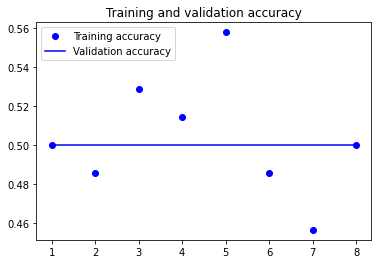

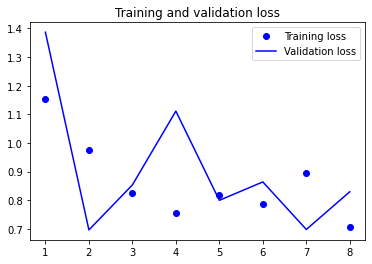

In [10]:
# Graficamos
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Como podemos ver, existe un underfitting de nuestro modelo, lo que quiere decir que no está aprendiendo suficiente del dataset. Es por esto que debemos realizar ajustes en los parámetros con el fin de que el modelo mejore. Además, los valores obtenidos del accuracy no son buenos, por lo que es necesario mejorar para que el modelo sea más preciso. 

In [11]:
# Realizamos data augmentation, ya que nos permite entrenar mejor el modelo teniendo más imágenes con las cuales entrenar este mismo. 
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.2)])

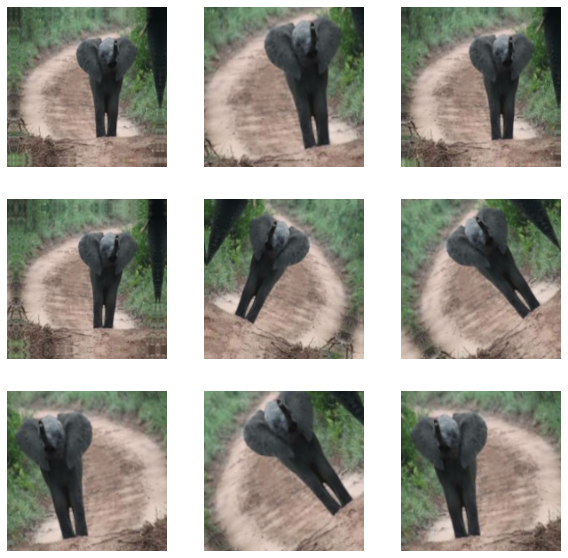

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [30]:
# Creación del modelo
model = keras.Sequential([keras.Input(shape=(180, 180, 3)),
                          layers.Rescaling(1./255),
                          layers.RandomFlip("horizontal"),
                          layers.RandomRotation(0.1),
                          layers.RandomZoom(0.2),
                          layers.Conv2D(filters=16, kernel_size=3, padding='same', activation="relu"),
                          layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu"),
                          #layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu"),
                          layers.MaxPooling2D(),
                          layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu"),
                          layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu"),
                          #layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu"),
                          layers.MaxPooling2D(),
                          layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu"),
                          layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu"),
                          layers.MaxPooling2D(),
                          layers.Flatten(),
                          layers.Dropout(0.2),
                          layers.Dense(128, activation="relu"),
                          layers.Dense(1, activation="sigmoid")])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip_4 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_4 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_4 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 32)      4640      
                                                      

In [31]:
# Compilación del modelo
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [32]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=60,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/60
5/5 [==============================] - 3s 290ms/step - loss: 0.8879 - accuracy: 0.5072 - val_loss: 0.7038 - val_accuracy: 0.5000
Epoch 2/60
5/5 [==============================] - 1s 270ms/step - loss: 0.6961 - accuracy: 0.4855 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/60
5/5 [==============================] - 1s 166ms/step - loss: 0.7009 - accuracy: 0.5072 - val_loss: 0.6928 - val_accuracy: 0.5072
Epoch 4/60
5/5 [==============================] - 1s 169ms/step - loss: 0.6939 - accuracy: 0.4928 - val_loss: 0.6951 - val_accuracy: 0.5000
Epoch 5/60
5/5 [==============================] - 1s 222ms/step - loss: 0.6946 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.5145
Epoch 6/60
5/5 [==============================] - 1s 166ms/step - loss: 0.6936 - accuracy: 0.4928 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/60
5/5 [==============================] - 1s 236ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6918 - val_accuracy: 0.5145
Epoch 8/60
5/5 [====

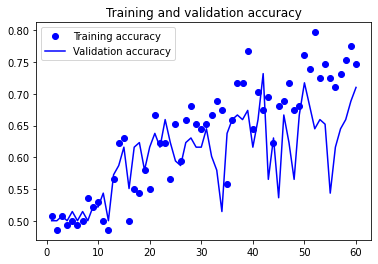

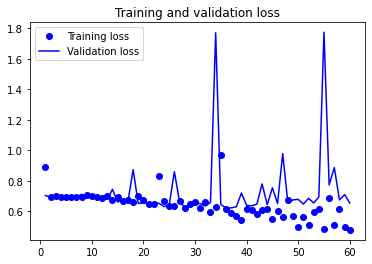

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Con la modificación del modelo, podemos ver que al inicio se observa un overfitting de los datos, pero después este se va rectificando. El modelo no tiene un accuracy muy alto, y a pesar de haber camiado la arquitectura del modelo, los hiperparámetros y realizado data augmentation, el accuracy del modelo no mejoró de manera considerable. 
Debemos tomar en cuenta que el dataset no se encuentra muy limpio, ya que contiene varias imágenes que no corresponden a la de un elefante y, aunado a eso, en algunas de las ocasiones se revuelven las dos categorías existentes (elefante asiático y africano), lo que hace que el modelo no pueda reconocer correctamente las diferencias entre cada uno. 
Para poder generar mejores predicciones sería necesario limpiar este dataset, eliminando imágenes no correspondientes a elefantes (como las de jirafa, zebra,continente africano) y asignar a cada fotografía el nombre correcto que indica a la clase a la que corresponde. 

Sí hubo una mejora en esta versión del modelo, agregando una capa densa, aumentando el número de épocas, eliminando el padding, y cambiando las funciones de activación. 

Al aumentar el número de épocas, el modelo puede aprender mejor sobre los datos y encontrar mejor patrones. Al agregar capas, el modelo es capaz de detectar o ir más a fondo con los detalles de la imagen, al contrario de si tuviéramos menor número de capas. Y finalmente, se modificaron las funciones de activación por otras que están más adecuadas al modelo. 

In [35]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

3/3 [==============================] - 1s 231ms/step - loss: 0.7125 - accuracy: 0.5556
Test accuracy: 0.556
